In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import linear_model
import statsmodels.api as sm
from DLtools.Data import load_data,instant_data,intersection
from DLtools.evaluation_rec import real_eva_error, error_rec


In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Load data

In [1]:
# loaddata = load_data()
# ame = loaddata.df_rain
# kawa = loaddata.df_water
# tenki = loaddata.df_weather
# dam = loaddata.df_dam

# df_d = loaddata.daily()
# df_h = loaddata.hourly()


In [7]:
loading = instant_data()
df_d = loading.daily_instant()

In [13]:
data=df_d["2013-01-01":"2017-12-31"].interpolate(limit=360).fillna(0)
TARGET = 'CPY015_wl'

In [14]:
#Shif target date
n_out = 7
data[TARGET]=data[TARGET].shift(-n_out)
data = data.dropna()

# MAR feature selection

In [15]:
mar = pd.read_csv('/home/song/Public/Song/Work/Thesis/featurelist_MAR_Day_ahead7d.csv')
col = [i for i in df.columns]
select_col = intersection(col,mar['feature'])




In [16]:

select_col.append(TARGET) # add target
df_d = df_d[select_col]

# Feature selection

In [65]:
def high_corr(data,threshold=.95):
    """Eliminate first columns with high corr"""
    
    corr_matrix = data.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop

In [66]:
def corr_w_Y(data,target,threshold= 0.3):
    # correlation 
    corr_test = data.corr(method='pearson')[target]
    corr_test = corr_test[(corr_test> threshold) | (corr_test< -threshold) ]
    corr_test = corr_test.sort_values(ascending=False)
    #corr_test =corr_test[1:] # eliminate Target it own
    return corr_test

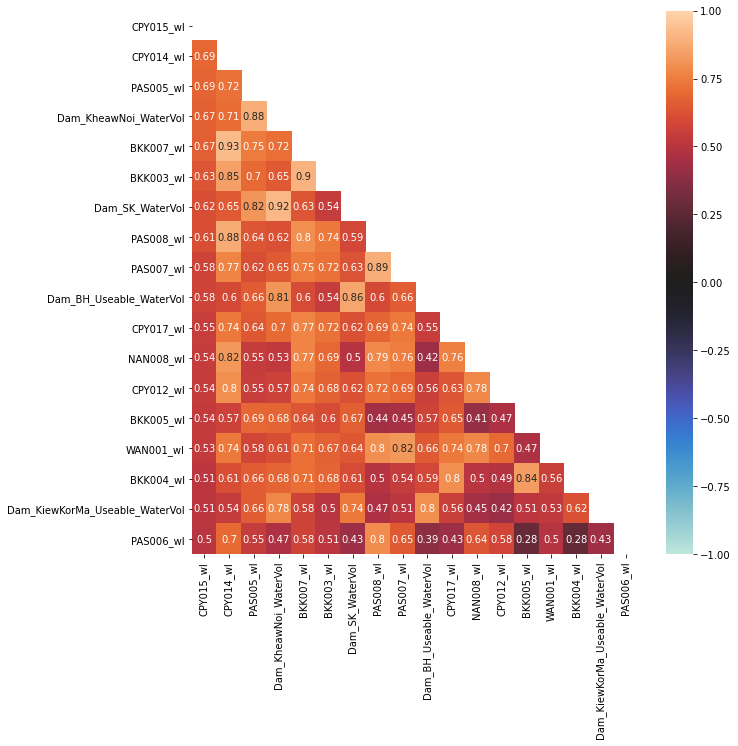

In [68]:
col_feature = corr_w_Y(data,TARGET,0.5).index
data = data[col_feature]

high_col = high_corr(data.iloc[:,1:]) #exclude target it own
data.drop(columns=high_col,inplace=True)
corr = data.corr()

plt.subplots(figsize=(10,10))
mask = np.triu(data.corr())
sns.heatmap(data.corr(), annot = True, vmin=-1, vmax=1, center= 0,mask=mask)
plt.savefig('output/Linear/Corr_timelag{}.png'.format(n_out), dpi=300, bbox_inches='tight')

# Linear Regression

In [17]:
X = data.drop(columns=[TARGET]).interpolate(limit=500)
Y = data[TARGET].interpolate(limit=500)

trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, shuffle=False)

In [18]:
regr = linear_model.LinearRegression()
regr.fit(trainX,trainY)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 0.7936810385577631
Coefficients: 
 [-8.74651447e-05 -1.15526544e-03 -1.86687068e-03  2.48684969e-05
  2.32334113e-03 -1.18387331e-03 -6.77222799e-05  1.91321730e-02
  4.34216840e-02  1.33911949e-02 -1.96753352e-02 -1.26067707e-02
  2.86348144e-02 -8.54429122e-04 -1.23988609e-03 -2.10519596e-04
 -5.14207954e-05  1.02716544e-03 -3.95195212e-02 -4.65006495e-04
 -3.91596446e-03  6.61115307e-04  2.10161667e-02 -1.08057639e-03
 -6.14804437e-03 -1.20539323e-03  1.98256278e-04 -3.96114663e-04
 -1.34181293e-03  1.50876342e-03  1.66339007e-04  7.42053157e-04
  1.69194087e-03]


In [61]:
# with statsmodels
#X = sm.add_constant(trainX) # adding a constant
 
#model = sm.OLS(trainY, trainX).fit()
#predictions = model.predict(trainX) 
#model.summary()

# Evaluation

In [22]:
trainPredict = regr.predict(trainX)
train_set_mse = (mean_squared_error(trainY, trainPredict))
train_set_r2 = r2_score(trainY, trainPredict)
print(train_set_mse)
print(train_set_r2)

testPredict = regr.predict(testX)
test_set_mse = ((mean_squared_error(testY, testPredict)))
test_set_r2 = r2_score(testY, testPredict)
print(test_set_mse)
print(test_set_r2)


mse, nse,r2 = real_eva_error(trainY, trainPredict)
Tmse, Tnse,Tr2 = real_eva_error(testY, testPredict)

0.019108839228856443
0.5742840133069631
0.03184036716445909
0.4518065008450953


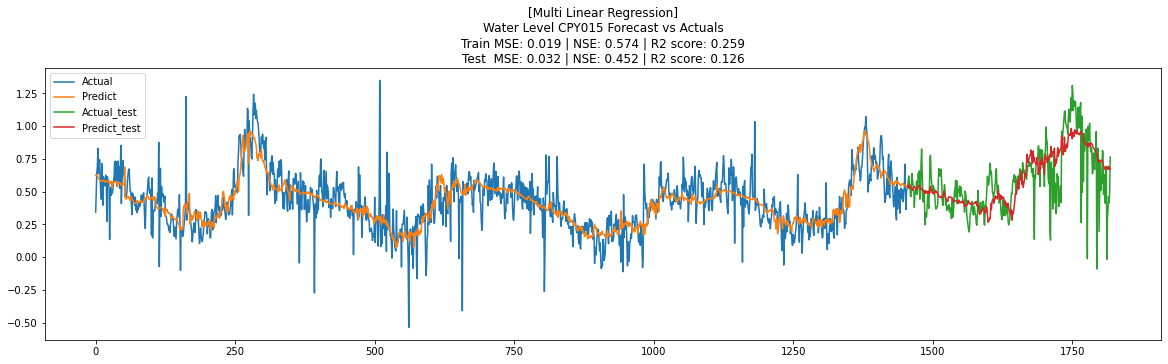

<Figure size 432x288 with 0 Axes>

In [23]:
index = np.arange(len(trainY)+len(testY))

Y= pd.Series(data=trainY.values,index=index[:len(trainY)])
Yhat = pd.Series(data=(trainPredict),index=index[:len(trainY)])
Y_t= pd.Series(data=testY.values,index=index[-len(testY):])
Yhat_t = pd.Series(data=(testPredict),index=index[-len(testY):])

plt.figure(figsize=(20,5))
plt.plot(Y, label = "Actual")
plt.plot(Yhat, label = "Predict")

plt.plot(Y_t, label = "Actual_test")
plt.plot(Yhat_t, label = "Predict_test")
plt.title('[Multi Linear Regression]\nWater Level CPY015 Forecast vs Actuals\n'+'Train MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (mse,nse,r2)+'\nTest  MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (Tmse,Tnse,Tr2))
plt.legend()
plt.show()

plt.savefig('output/Linear/result_MAR_Linear.png', dpi=300, bbox_inches='tight')



# fig,ax = plt.subplots(2,1,figsize=(20,5),constrained_layout=True)
# ax[0].plot(Y,label="Actual")
# ax[0].plot(Yhat,label="Predict")
# ax[0].set_ylabel('Water level(mm)')
# ax[0].legend()

# ax[1].plot(Y_t,label="Actual")
# ax[1].plot(Yhat_t,label="Predict")
# ax[1].set_ylabel('Water level(mm)')
# ax[1].legend()

# plt.show()
# plt.savefig('output/Linear_fig.png')

Plot

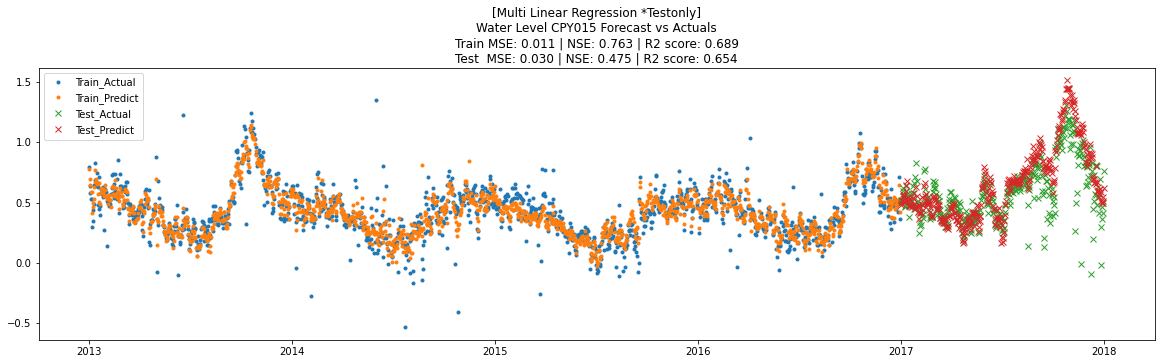

In [14]:
# plt.figure(figsize=(20,5))
# plt.plot(trainY.sort_index(),'.',label="Train_Actual")
# plt.plot(trainPredict.sort_index(),'.',label="Train_Predict")
# plt.plot(testY.sort_index(),'x',label="Test_Actual")
# plt.plot(testPredict.sort_index(),'x',label="Test_Predict")
# plt.title('[Multi Linear Regression *Testonly]\nWater Level CPY015 Forecast vs Actuals\n'+'Train MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (mse,nse,r2)+'\nTest  MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (Tmse,Tnse,Tr2))

# plt.legend()
# plt.show()
# #plt.savefig('output/Linear/result_Linear.png', dpi=300, bbox_inches='tight')

In [24]:
mse_train,nse_train,r2_train = real_eva_error(trainPredict,trainY.values)
mse_test,nse_test,r2_test = real_eva_error(testPredict,testY.values)
print("MSE.........|.......NSE|........R2")
print(mse_train,"|",nse_train,"|",r2_train)
print(mse_test,"|",nse_test,"|",r2_test)


MSE.........|.......NSE|........R2
0.019108839228856443 | 0.25870131010336184 | 0.5742840133069631
0.03184036716445909 | 0.12605082360691222 | 0.4518065008450953


Record

In [25]:
idx=['Modelname','Feature','n_in_time','batchsize','mse','nse','r2','Test_mse','Test_nse','Test_r2','Intercept','Coefficients']
col = ['MultiLinearReg']
error = pd.DataFrame(["MultiLinearReg",[data.columns],"None",'None',mse, nse,r2,Tmse, Tnse,Tr2,[regr.intercept_], [regr.coef_]],index=idx,columns=col)
error.to_csv('output/Linear/evaluation_MAR_Linear.csv')

# LOOP

0.015896206406206453
0.6452061208000097
0.06437791518474285
-0.11119279206741561


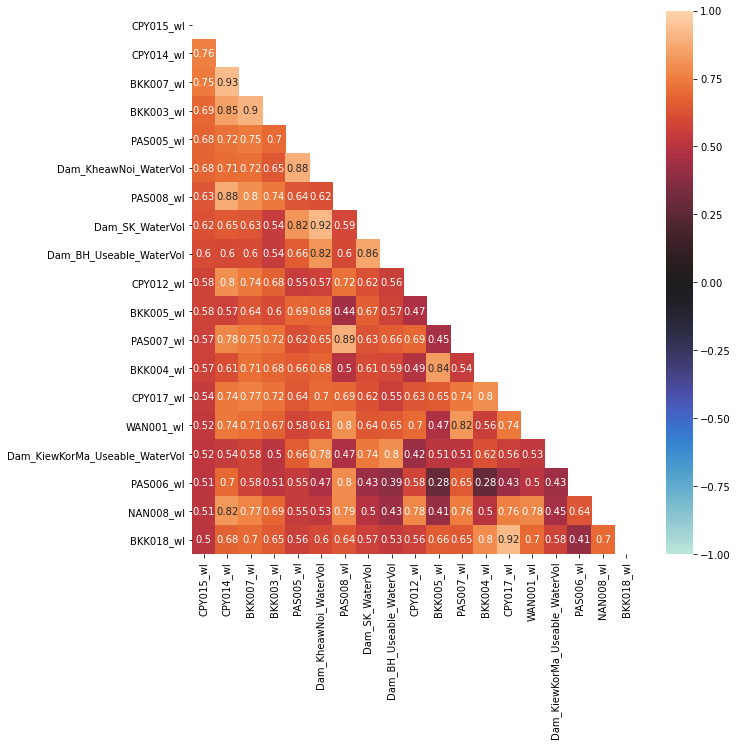

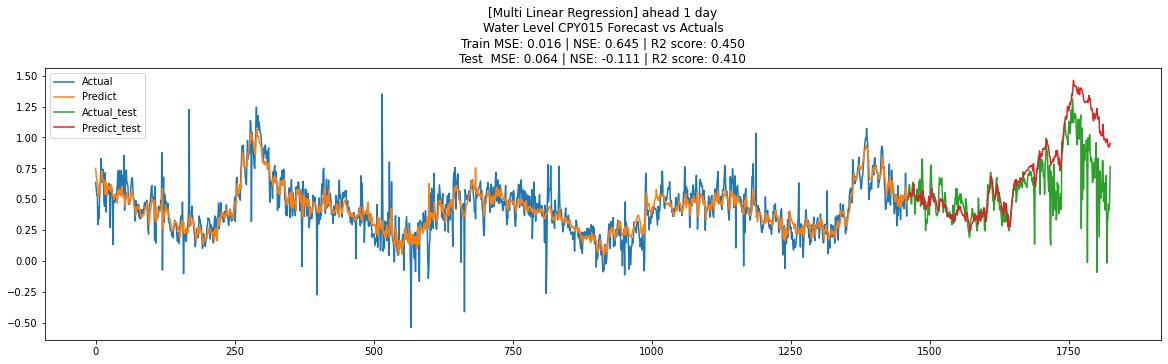

0.017228071080136888
0.6154669996703845
0.08940455416640378
-0.5431642339243226


<Figure size 432x288 with 0 Axes>

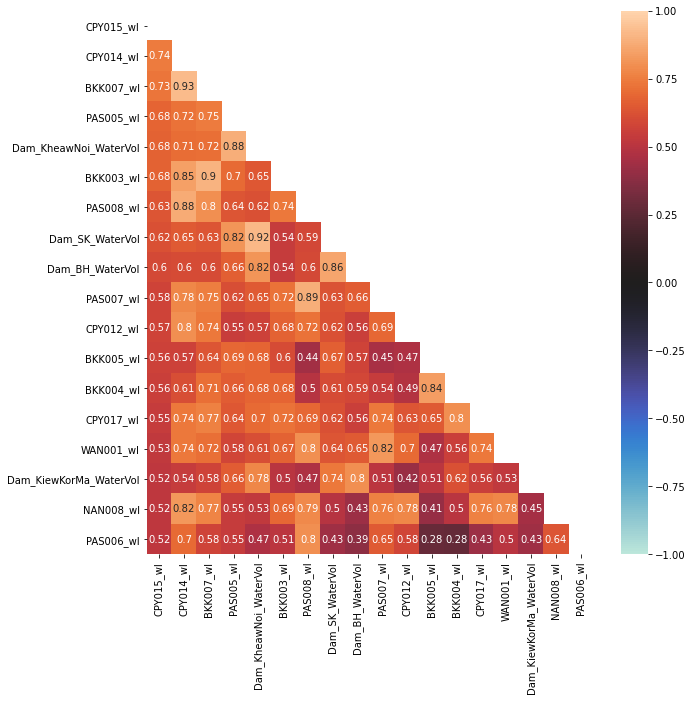

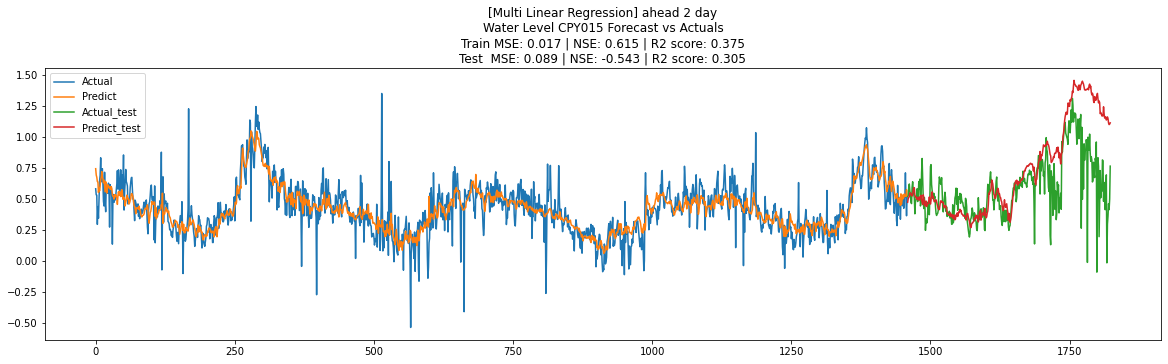

0.018095053651950604
0.5962304494717237
0.10045508478988188
-0.7339015378909353


<Figure size 432x288 with 0 Axes>

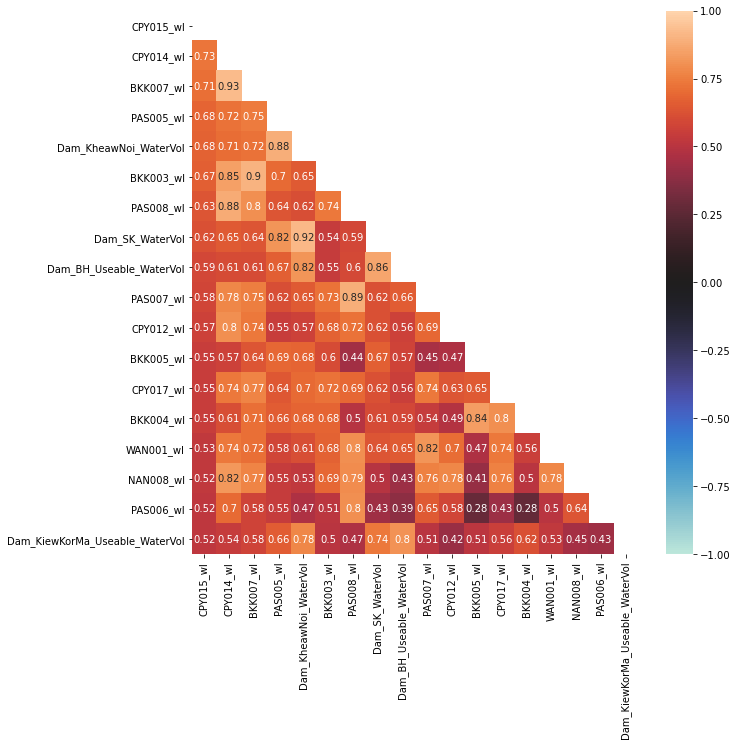

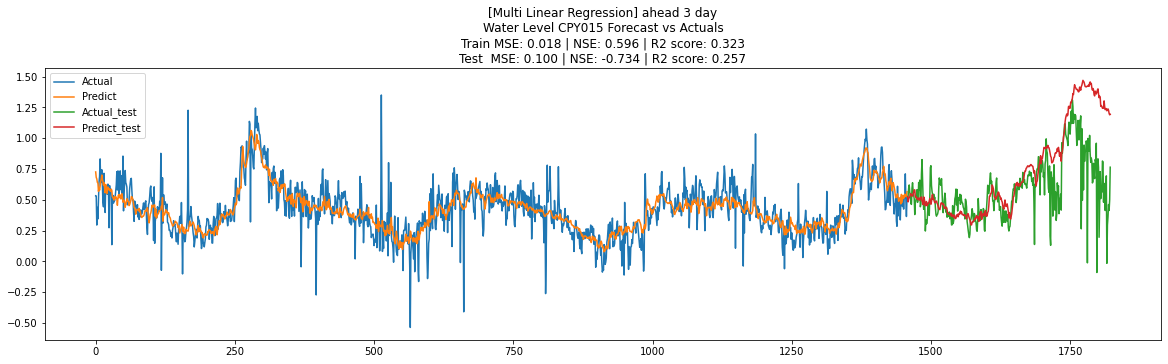

0.01876449775669817
0.5814982378313607
0.11614271291261372
-1.0046773038440544


<Figure size 432x288 with 0 Axes>

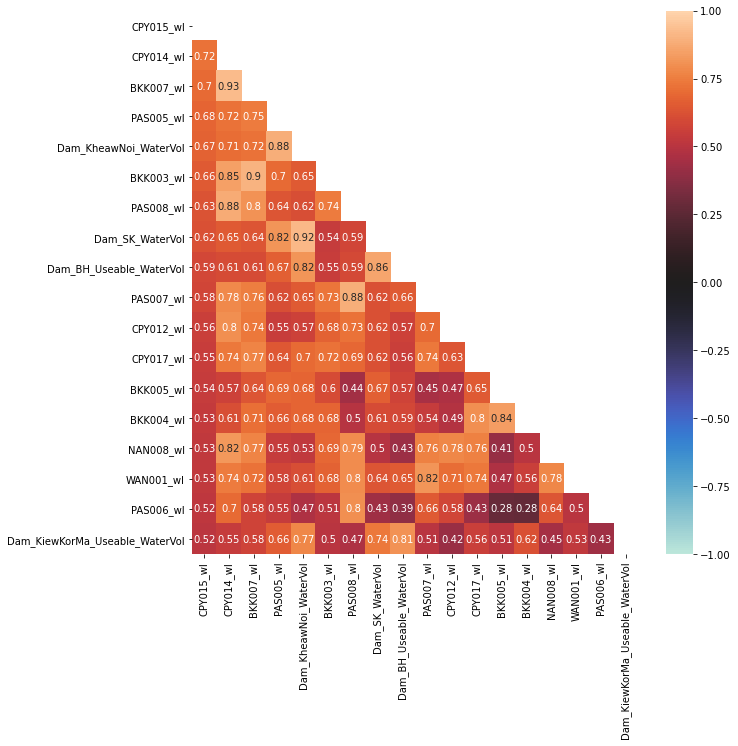

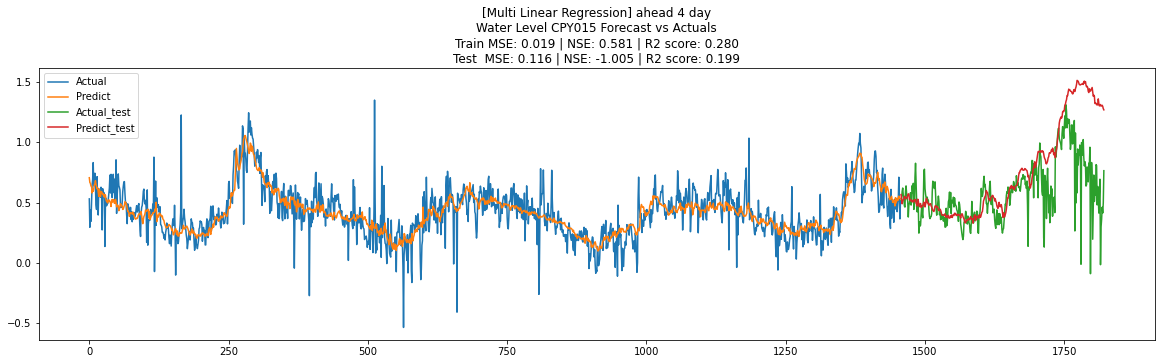

0.019187525991052008
0.5722766943747633
0.14763032242050833
-1.5481681053743603


<Figure size 432x288 with 0 Axes>

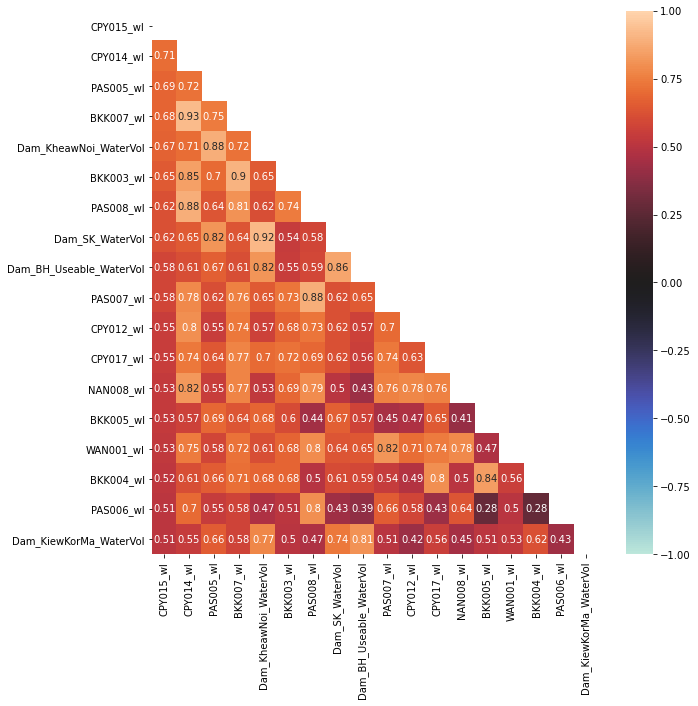

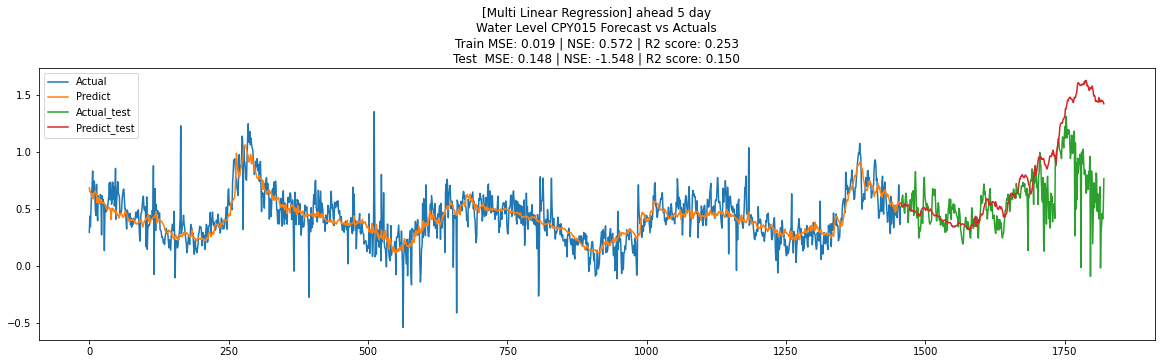

0.01957775150852594
0.5635398418391505
0.1381451800585322
-1.3784364437921104


<Figure size 432x288 with 0 Axes>

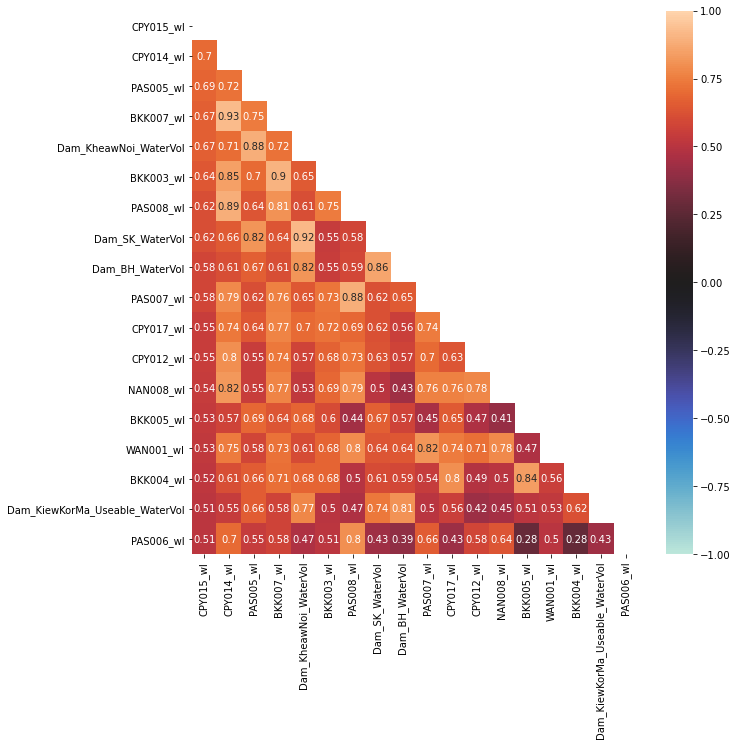

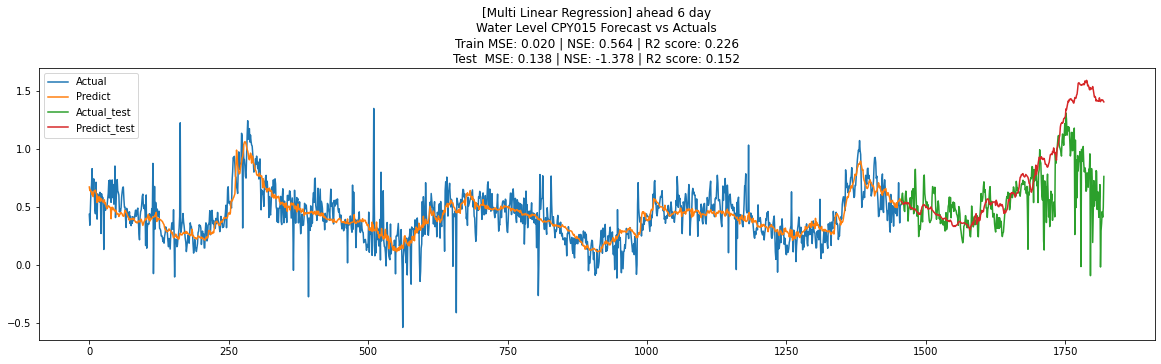

0.019822323317450596
0.5583886687950391
0.14770105588953433
-1.542959327031162


<Figure size 432x288 with 0 Axes>

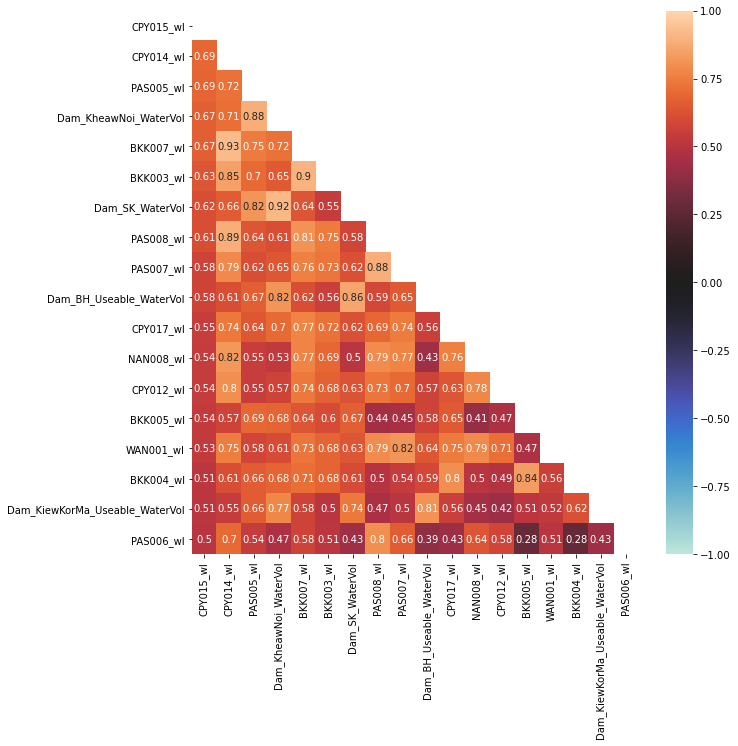

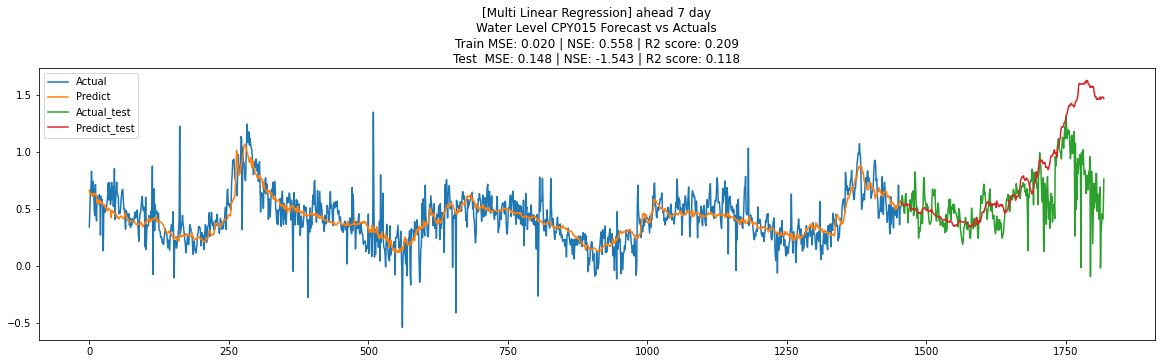

<Figure size 432x288 with 0 Axes>

In [80]:
#n_out = 7

error=pd.DataFrame()
for n_out in range(1,8):
    data=df_d["2013-01-01":"2017-12-31"].interpolate(limit=360).fillna(0)
    TARGET = 'CPY015_wl'
    data[TARGET]=data[TARGET].shift(-n_out)
    data = data.dropna()
    col_feature = corr_w_Y(data,TARGET,0.5).index
    data = data[col_feature]

    high_col = high_corr(data.iloc[:,1:]) #exclude target it own
    data.drop(columns=high_col,inplace=True)
    corr = data.corr()

    plt.subplots(figsize=(10,10))
    mask = np.triu(data.corr())
    sns.heatmap(data.corr(), annot = True, vmin=-1, vmax=1, center= 0,mask=mask)
    plt.savefig('output/Linear/Corr_timelag{}.png'.format(n_out), dpi=300, bbox_inches='tight')
    X = data.drop(columns=[TARGET]).interpolate(limit=500)
    Y = data[TARGET].interpolate(limit=500)

    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, shuffle=False)
    regr = linear_model.LinearRegression()
    regr.fit(trainX,trainY)
    trainPredict = regr.predict(trainX)
    train_set_mse = (mean_squared_error(trainY, trainPredict))
    train_set_r2 = r2_score(trainY, trainPredict)
    print(train_set_mse)
    print(train_set_r2)

    testPredict = regr.predict(testX)
    test_set_mse = ((mean_squared_error(testY, testPredict)))
    test_set_r2 = r2_score(testY, testPredict)
    print(test_set_mse)
    print(test_set_r2)


    mse, nse,r2 = real_eva_error(trainY, trainPredict)
    Tmse, Tnse,Tr2 = real_eva_error(testY, testPredict)
    index = np.arange(len(trainY)+len(testY))

    Y= pd.Series(data=trainY.values,index=index[:len(trainY)])
    Yhat = pd.Series(data=(trainPredict),index=index[:len(trainY)])
    Y_t= pd.Series(data=testY.values,index=index[-len(testY):])
    Yhat_t = pd.Series(data=(testPredict),index=index[-len(testY):])

    plt.figure(figsize=(20,5))
    plt.plot(Y, label = "Actual")
    plt.plot(Yhat, label = "Predict")

    plt.plot(Y_t, label = "Actual_test")
    plt.plot(Yhat_t, label = "Predict_test")
    plt.title('[Multi Linear Regression] ahead {} day'.format(n_out)+'\nWater Level CPY015 Forecast vs Actuals\n'+'Train MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (mse,nse,r2)+'\nTest  MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (Tmse,Tnse,Tr2))
    plt.legend()
    plt.show()
    plt.savefig('output/Linear/result_Linear_{}d.png'.format(n_out), dpi=300, bbox_inches='tight')

    idx=['Modelname','Feature','n_in_time','batchsize','mse','nse','r2','Test_mse','Test_nse','Test_r2','Intercept','Coefficients']
    col = ['MultiLinearReg']
    _df = pd.DataFrame(["MultiLinearReg",[data.columns],"None",'None',mse, nse,r2,Tmse, Tnse,Tr2,[regr.intercept_], [regr.coef_]],index=idx,columns=col)
    error = pd.concat([error,_df],axis=1)
    error.to_csv('output/Linear/evaluation_Linear_{}d.csv'.format(n_out))